In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import norm, probplot
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMA time series model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

# Project organisation: 

This project is organised in two parts as follows: 

    - PART I) We start by exploring and visualizing the household power consumption dataset using exploratory data analysis to better understand the data and propose a business use case.
    
    - PART II) We prepare the dataset to eventually solve the business use case using machine learning techniques and assess the performance of the proposed models.

# PART I

The dataset contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

**Dataset attributes dictonary:**

    1.date: Date in format dd/mm/yyyy

    2.time: time in format hh:mm:ss

    3.global_active_power: household global minute-averaged active power (in kilowatt)

    4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

    5.voltage: minute-averaged voltage (in volt)

    6.global_intensity: household global minute-averaged current intensity (in ampere)

    7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

    8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

    9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

## I.1) Loading the data

In [2]:
df = pd.read_csv(
    'data/household_power_consumption.txt',
    sep=';',
    infer_datetime_format=True,  # parsing dates
    parse_dates={
        'datetime': ['Date', 'Time'] # dates to be parsed correspond to the first and second columns
    },
    index_col=['datetime'])

/home/lambda/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
print('shape:{}\n'.format(df.shape))
print('\n'.format(df.info()))

shape:(2075259, 7)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      object
Global_reactive_power    object
Voltage                  object
Global_intensity         object
Sub_metering_1           object
Sub_metering_2           object
Sub_metering_3           float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB




As stated earlier, the dataset is a multivariate time series that describes the electricity consumption for a single household over four years with a one-minute sampling rate. It is comprised of **2075259** observations and **7** features, besides the date and time, that are all <u>**continuous**</u> (See the attributes' dictionary above).

## I.2) Missing values:

In [5]:
df.isnull().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [6]:
df[df['Sub_metering_3'].isnull()].head(10)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-21 11:23:00,?,?,?,?,?,?,NaN
2006-12-21 11:24:00,?,?,?,?,?,?,NaN
2006-12-30 10:08:00,?,?,?,?,?,?,NaN
2006-12-30 10:09:00,?,?,?,?,?,?,NaN
2007-01-14 18:36:00,?,?,?,?,?,?,NaN
2007-01-28 17:13:00,?,?,?,?,?,?,NaN
2007-02-22 22:58:00,?,?,?,?,?,?,NaN
2007-02-22 22:59:00,?,?,?,?,?,?,NaN
2007-03-25 17:52:00,?,?,?,?,?,?,NaN


All missing values are comprised within the column **Sub_metering_3**. The correspoding rows of these missing values are not defined as well. So we are going to drop all these undefined rows.

In [7]:
# Dropping all nan values and converting dataframe to float to facilitate the computations
df = df.dropna()
df = df.astype('float32')

In [8]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float32
Global_reactive_power    float32
Voltage                  float32
Global_intensity         float32
Sub_metering_1           float32
Sub_metering_2           float32
Sub_metering_3           float32
dtypes: float32(7)
memory usage: 70.4 MB


## I.3) Adding Sub_metering_4 feature

Here, we are going to add a feature to the original dataset that represents the active energy consumed every minute (in watt hour) in the household by electrical equipments not measured in sub-meterings 1, 2 and 3.

In [10]:
df['Sub_metering_4'] = (df['Global_active_power'] * 1000 / 60 -
                        df['Sub_metering_1'] - df['Sub_metering_2'] -
                        df['Sub_metering_3'])

## I.4) Dataframe resampling:

The original dataset provides one-minute sampling rate observations. We will resample these observations by day, week and month to better understand them. For this, we use Pandas <i>resampling</i> method.

In [11]:
daily_df = df.resample('d').sum()
weekly_df = df.resample('w').sum()
monthly_df = df.resample('m').sum()

## I.5) Data visualization:

### I.5.1) Plotting all the features together

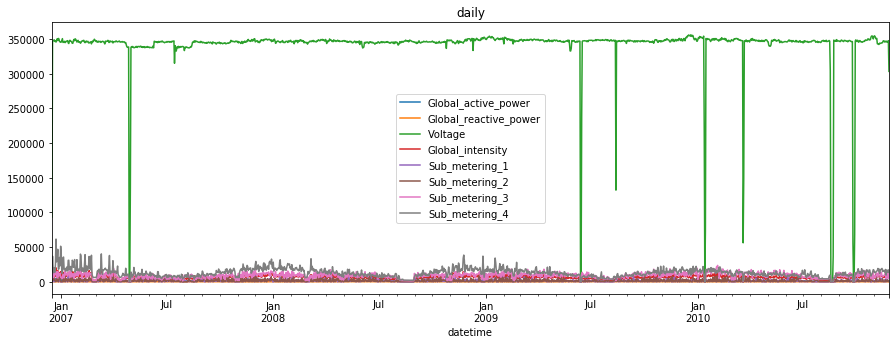

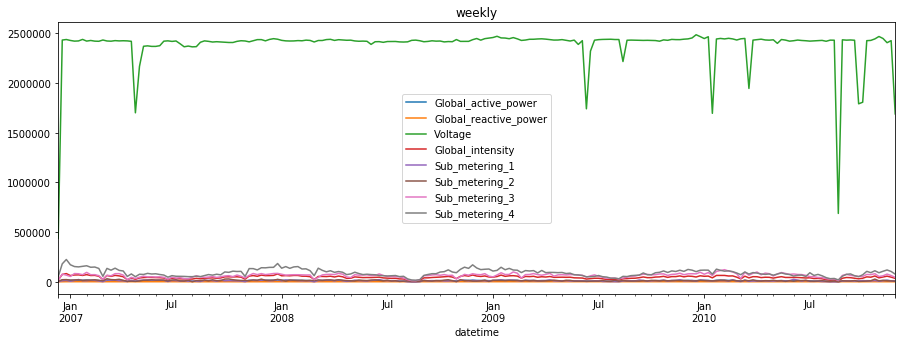

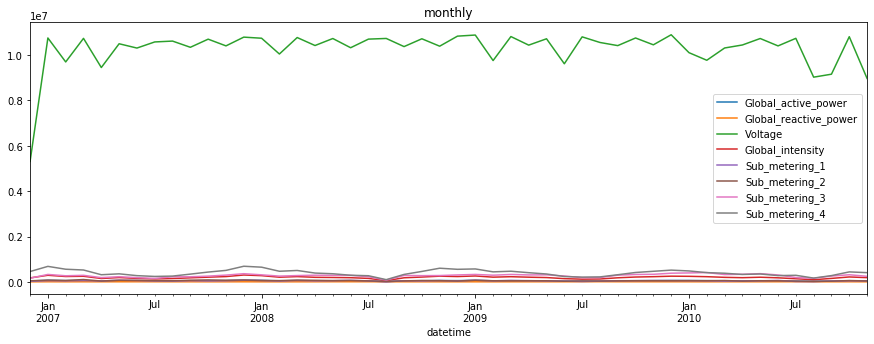

In [12]:
for rate, dataset in zip(['daily', 'weekly', 'monthly'],
                         [daily_df, weekly_df, monthly_df]):
    dataset.plot(title=rate, figsize=(15,5))
    plt.show()

**Voltage** is a feature that seems to be constant except for the sudden changes, that may be failures or maintenance breaks.

To see other features' evolution, we are going to drop the **Voltage** feature for a moment.

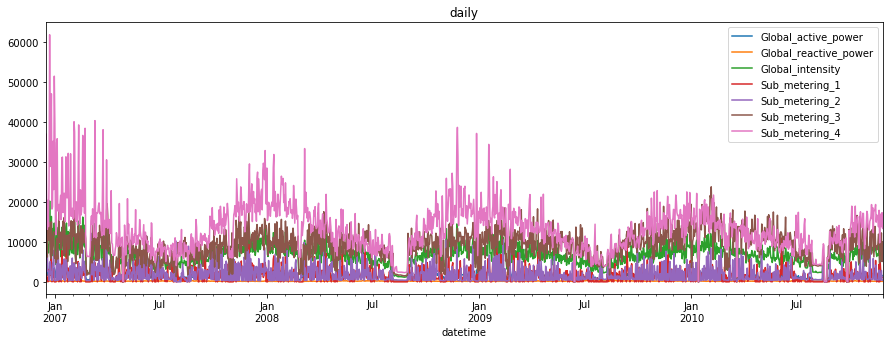

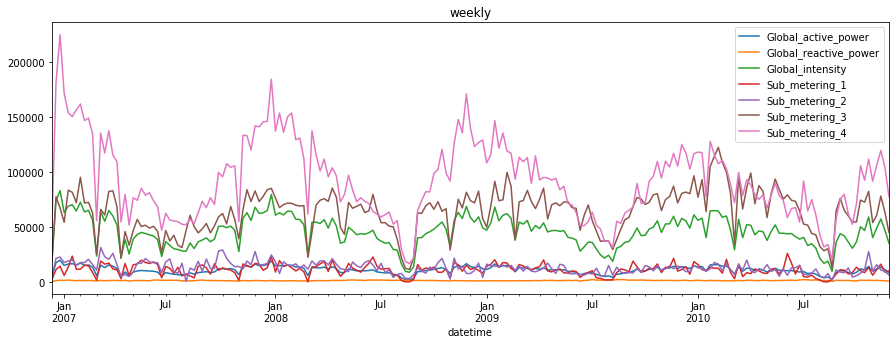

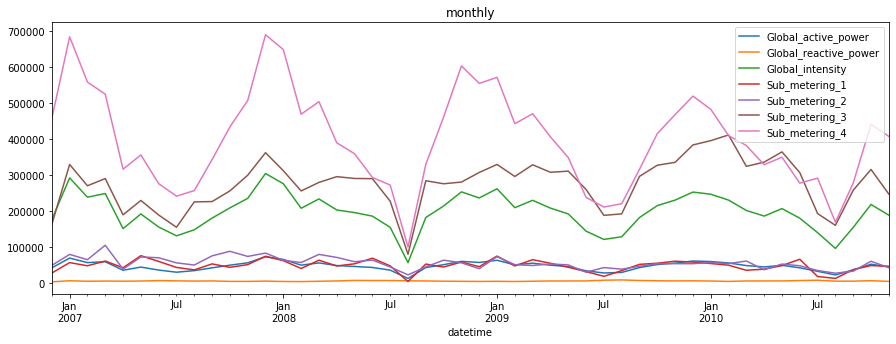

In [13]:
for rate, dataset in zip(['daily', 'weekly', 'monthly'],
                         [daily_df, weekly_df, monthly_df]):
    dataset.drop('Voltage', axis=1).plot(title=rate, figsize=(15,5))
    plt.show()

We can see some patterns in the energy consumption for different sub-meterings each year. We have to examine this in more details.

We are going to add some time features to the original dataset that are going to help us in the plots. 

### I.5.2) Energy consumption by sub-meterings during different part of the year

In [14]:
# Adding time features to the original dataframe
df['dow'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour

In [15]:
plt.rcParams['figure.figsize'] = 24, 10

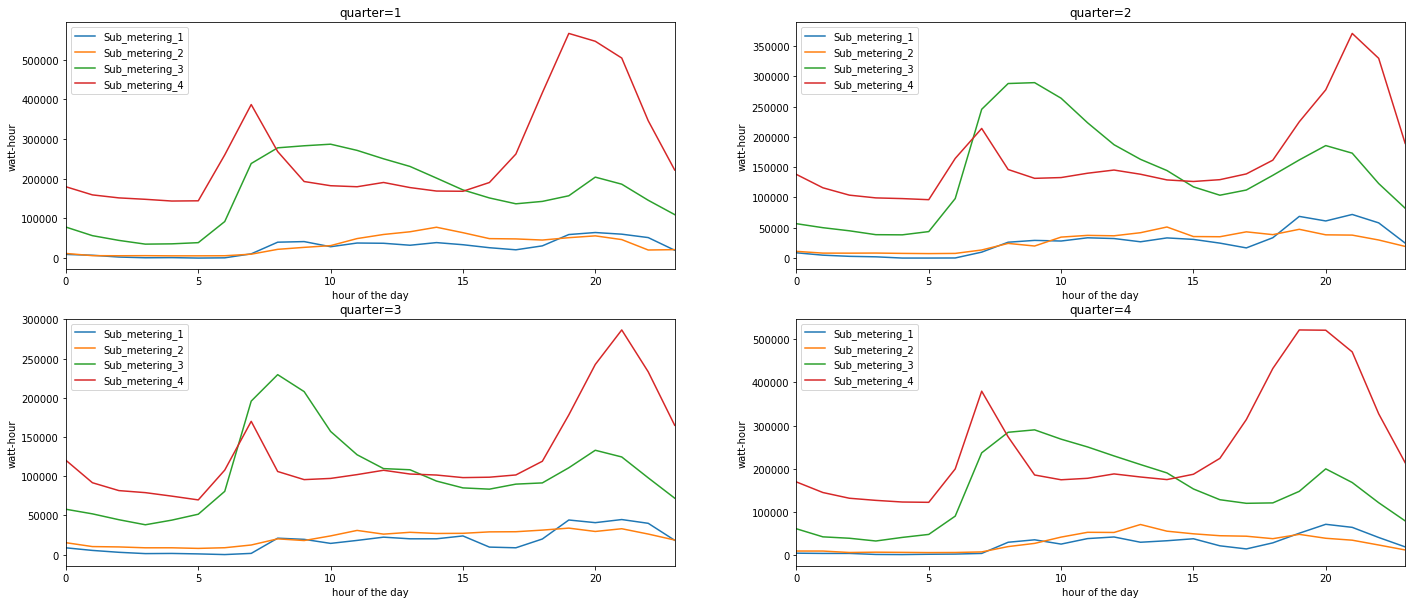

In [16]:
for quarter in range(1, 5):
    plt.subplot(2, 2, quarter)
    df[df['quarter'] == quarter].groupby(df[
        df['quarter'] == quarter].index.hour)['Sub_metering_1'].sum().plot()
    df[df['quarter'] == quarter].groupby(df[
        df['quarter'] == quarter].index.hour)['Sub_metering_2'].sum().plot()
    df[df['quarter'] == quarter].groupby(df[
        df['quarter'] == quarter].index.hour)['Sub_metering_3'].sum().plot()
    df[df['quarter'] == quarter].groupby(df[
        df['quarter'] == quarter].index.hour)['Sub_metering_4'].sum().plot()
    plt.legend()
    plt.xlabel('hour of the day')
    plt.ylabel('watt-hour')
    plt.title('quarter={}'.format(quarter))
plt.show()

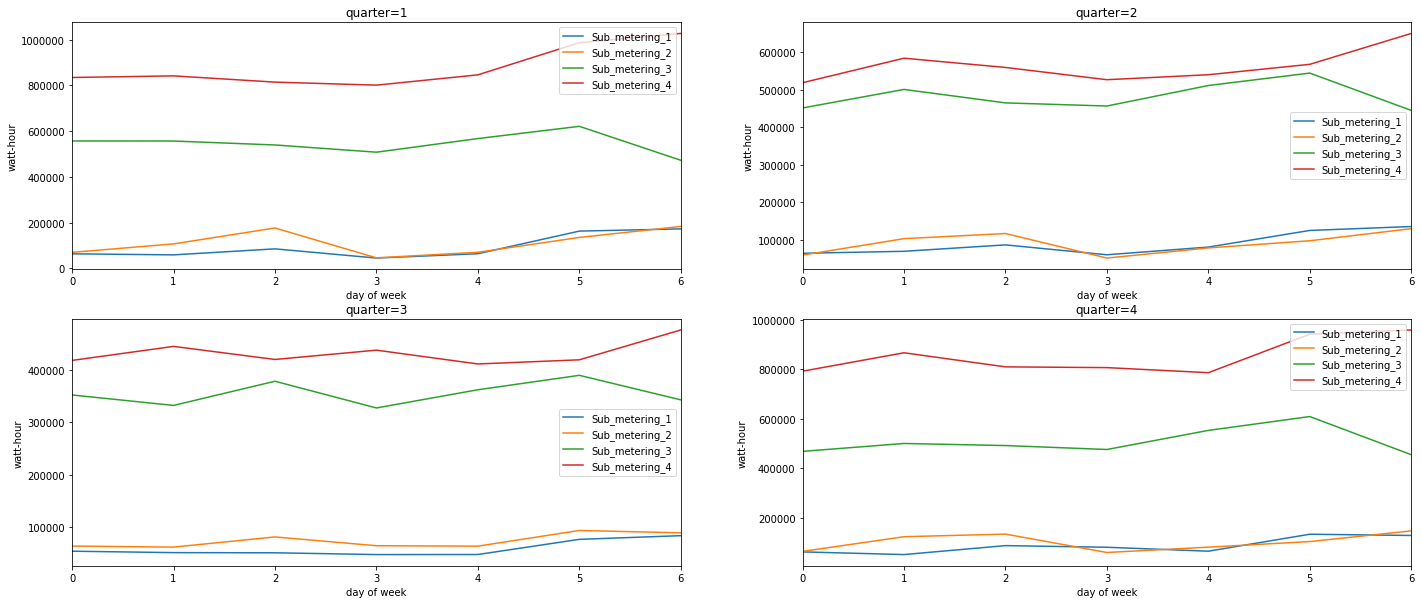

In [17]:
for quarter in range(1, 5):
    plt.subplot(2, 2, quarter)
    df[df['quarter'] == quarter].groupby(
        df[df['quarter'] ==
           quarter].index.dayofweek)['Sub_metering_1'].sum().plot()
    df[df['quarter'] == quarter].groupby(
        df[df['quarter'] ==
           quarter].index.dayofweek)['Sub_metering_2'].sum().plot()
    df[df['quarter'] == quarter].groupby(
        df[df['quarter'] ==
           quarter].index.dayofweek)['Sub_metering_3'].sum().plot()
    df[df['quarter'] == quarter].groupby(
        df[df['quarter'] ==
           quarter].index.dayofweek)['Sub_metering_4'].sum().plot()
    plt.legend()
    plt.xlabel('day of week')
    plt.ylabel('watt-hour')
    plt.title('quarter={}'.format(quarter))
plt.show()

We see that the daily energy consumption in all the sub-meterings is distributed in roughly the same way during the whole year. 

Specifically, we see a pick early in the morning and a pick later in the evening in **Sub_metering_3** and **Sub_metering_4**.

Regarding **Sub_metering_3**, this may be explained by the use of the electric water heater for daily showering. And for **Sub_metering_4**, this may include television, radio to listen to the news in the morning and the use of television and/or computers for entertainment later in the evening after a day at work and also during weekends.

As for **Sub_metering_2**, we see that the laundering activity is sometimes in the middle of the week and some others in sundays.

For **Sub_metering_1**, this may be explained by using the kitchen in the evening to cook diner. Sometimes there is an activity during the day, which may be the case of bank holidays. In weekends, we see that the energy consumption in the kitchen drops down, meaning that the family maybe is eating out or traveling.


## I.6) Problem framing:

There are several ideas that can be done to frame this problem into a business use case solvable using machine learning techniques. For example, we can:
    - Forecast hourly consumption for the next day.
    - Forecast daily consumption for the next week.
    - Forecast daily or weekly consumption for the next month.
    - Forecast monthly consumption for the next year.
    - Extract patterns of behaviour regarding energy consumption using clustering techniques.

In the reminder of this project we are going to work on <u>**forecast daily consumption for the next week**</u>.

# PART II

In this part, we are going to compare two machine learning models, that are **SARIMA** for time series prediction and **Multivariate Linear Regression**, to solve the problem of daily forecasting of energy consumption for the next week using the original dataframe resampled into days. 

## II.1) SARIMA

### II.1.1) Preparing the dataset

For SARIMA, we are going to work only with the **'Global_active_power'** feature as a univariate time series. 

In [18]:
# extracting the 'Global_active_power' feature series from the daily dataframe
series = daily_df['Global_active_power']
print('Data Summary:')
print(series.describe())

Data Summary:
count    1442.000000
mean     1551.334961
std       617.297058
min         0.000000
25%      1161.198486
50%      1534.778015
75%      1889.859528
max      4773.386230
Name: Global_active_power, dtype: float64


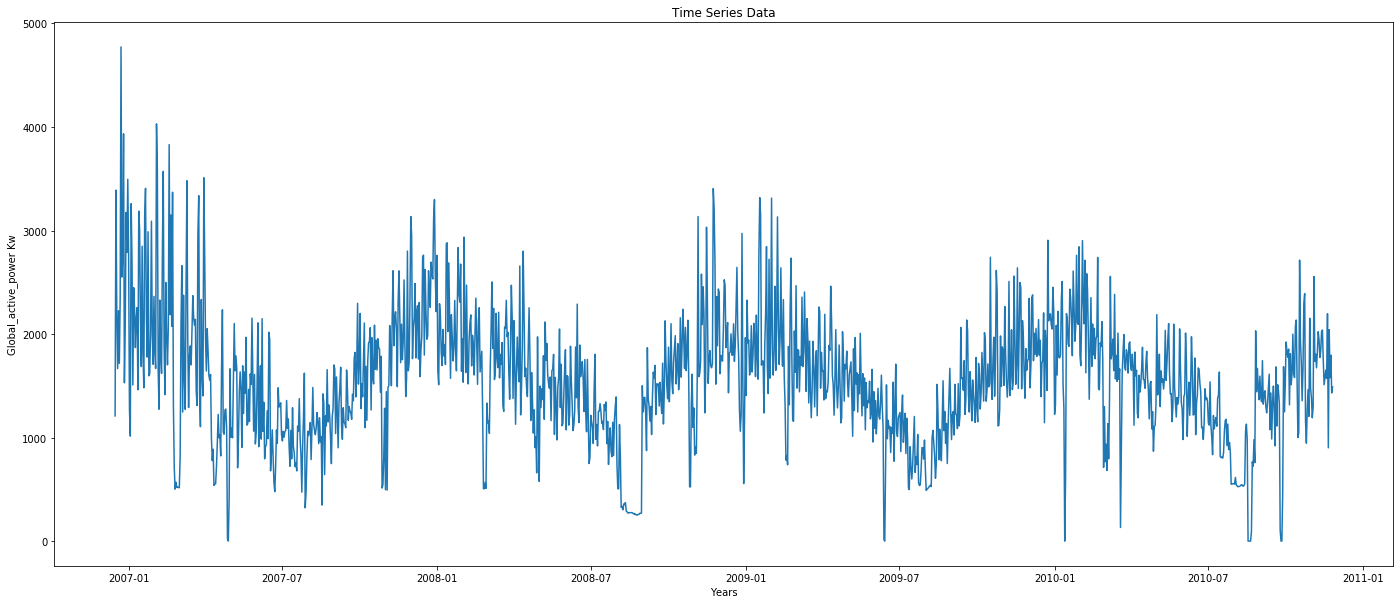

In [19]:
# Plot data for visualization
plt.plot(series);
plt.title("Time Series Data");
plt.xlabel("Years");
plt.ylabel("Global_active_power Kw");

From inspecting the plot of the series, we can conclude that this time series has not any positive linear trend, but has multiplicative seasonal patterns. Therefore, there is no need to differenciate it.

We can also see that the time series is stationary.

### Split data into training and testing sets

The daily dataset will be split into several weeks, then we hold the last week to make prediction and train on the rest.

Concretly, we have the daily observations dataset: [d1, d2, ..., dn]

We split it into several weeks: [w1, w2, ... ,wm] where:
    - wi=[di, .., d(i+7)]
    - m<n
    
Then the train/test will be performed in several folds as follows:

| Train | Test |
| --- | --- |
| w1, w2 | w3 |
| w1, w2, w3  | w4 |
| w1, w2, w3, w4 | w5 |

In [20]:
def split_series_to_weeks(series):
    '''
    function that takes as argument daily series and split it into weeks.
    '''
    folds = []

    for i in range(2, len(series), 7):
        folds.append(series[i:i + 7])

    return folds

def split_weekly_train_test(series):
    '''
    function that takes as argument daily series, split it into weeks
    and prepares the training/testing set using walk forward validation.
    '''
    folds = split_series_to_weeks(series)
    training = []
    testing = []
    
    for i in range(2, len(folds)):
        training.append(folds[:i])
        testing.append(folds[i])
        
    return training, testing

In [21]:
training_testing_folds = split_weekly_train_test(series)

### ACF and PACF plot analysis 

/home/lambda/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/home/lambda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.
/home/lambda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behavi

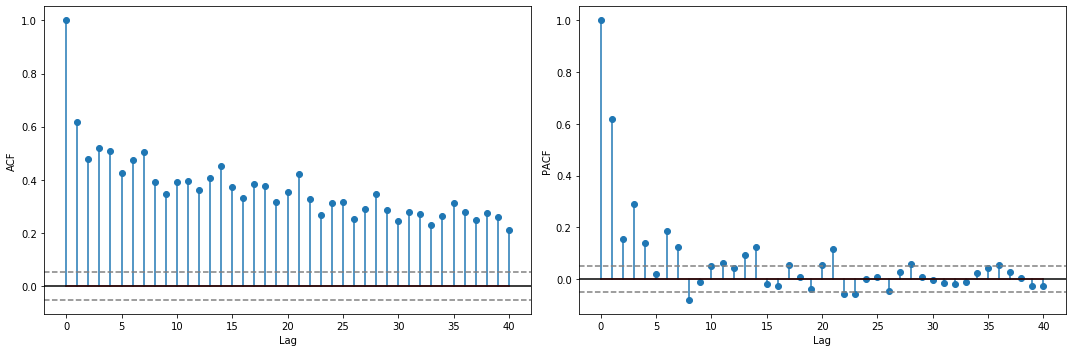

In [23]:
# import acf/pacf functions and run them on the training data
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(series, nlags=40)
lag_pacf = pacf(series, nlags=40, method='ols')

# Plot ACF:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.stem(lag_acf)
plt.axhline(y=0, linestyle='-', color='black')
plt.axhline(y=-1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
plt.xlabel('Lag')
plt.ylabel('ACF')

# Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf)
plt.axhline(y=0, linestyle='-', color='black')
plt.axhline(y=-1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.tight_layout()

### SARIMA(p,d,q)(P,D,Q) model fit and evaluation

Looking at the ACF and PACF plots of the series we see our first significant value at lag 1 for ACF and at the same lag 1 for the PACF which suggest to use **p = 1** and **q = 1**. We also have a big lag at 7 in the ACF plot which suggests our season is **S = 7** and since this lag is positive it suggests **P = 1** and **Q = 0**. Since this is not a differenced series for SARIMA we set **d = 0**. 

All together this gives us a **SARIMA(1,0,1)(1,0,0)** model.

Next we run SARIMA with these values for forecasting.

In [24]:
def fit_and_evaluate(training_testing_folds, plot=False):
    '''
    function that fits and evaluates SARIMA model.
    plot: boolean to plot the results of the last train/test fold.
    '''
    # saving the training results
    fitted_model = []

    # saving the test results
    forecasted_values = []

    # performance array
    rmse_scores = []

    for training_fold, testing_fold in zip(training_testing_folds[0],
                                           training_testing_folds[1]):
        # training_fold is a list of series. We concatenate it to form one pandas series
        model = SARIMAX(pd.concat(training_fold),
                        order=(1, 0, 1),
                        seasonal_order=(1, 0, 0, 7),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        # extract the fitted model
        model_fit = model.fit(disp=False)

        # store training results
        fitted_model.append(model_fit.fittedvalues)

        # ----forecasting----
        # number of future time steps we want to forecast
        forecasting_steps = len(testing_fold)

        # apply the model to forecast out the time steps
        forecast = model_fit.forecast(forecasting_steps)

        # store testing results
        forecasted_values.append(forecast)

        # store model performance RMSE
        rmse_scores.append(
            np.sqrt(sum((forecast - testing_fold)**2) / len(testing_fold)))

    if plot:
        # Training vs fitted model
        plt.plot(pd.concat(training_fold), label='Training')
        plt.plot(fitted_model[-1], 'r', alpha=0.5, label='Fitted')
        plt.legend(loc='upper right')
        plt.title("SARIMA fitted model to training data.")
        plt.xlabel("Years")
        plt.ylabel("Global_active_power (Kw)")
        plt.show()

        # Residuals
        model_fit.plot_diagnostics(figsize=(24, 10))
        plt.show()

    return fitted_model, forecasted_values, rmse_scores

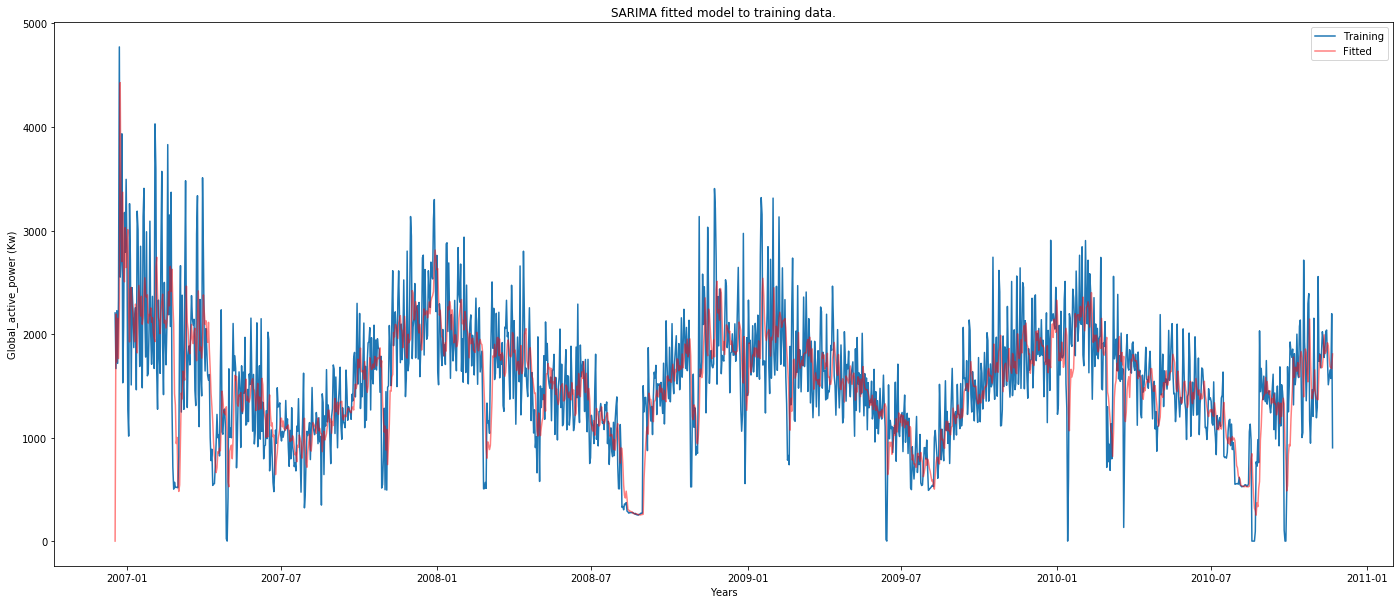

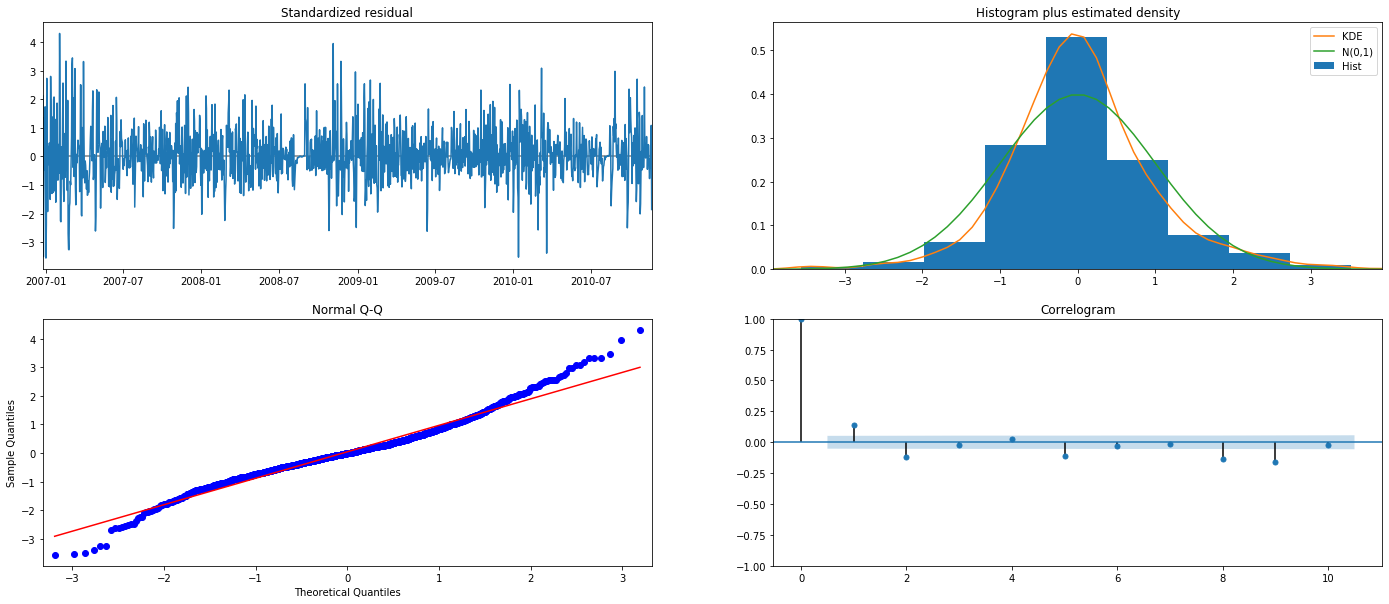

In [25]:
# fitting the model and plotting the last fold results
fitted_model, forecasted_values, rmse_scores = fit_and_evaluate(
    training_testing_folds, True)

Looking at the fitted model on top of the training data we see it's not exactly a perfect fit. But looking at the correlogram and probability plot of the residual series we see that the residual is close to being gaussian noise, we still have a few minor points extending outside the significance lines. Nevertheless, our model diagnostics suggests that the residuals are near normally distributed.

For the most part, this is fine. We could go back and experiment with different SARIMA parameters until the fit looks perfect and the irregular component becomes 100% noise. But by doing this we also risk overfitting the model to the training so we will keep the current parameters and move forward now to forecasting.

### Multistep forecasting performance

### SARIMA

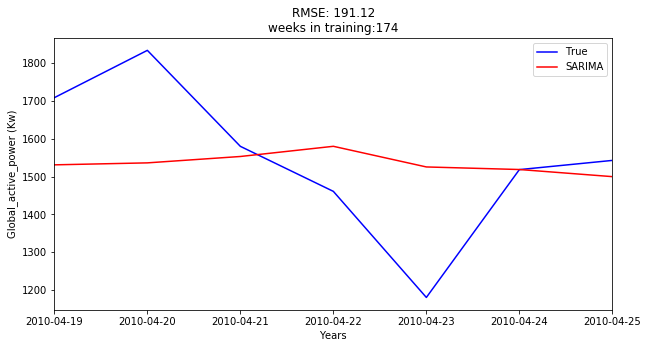

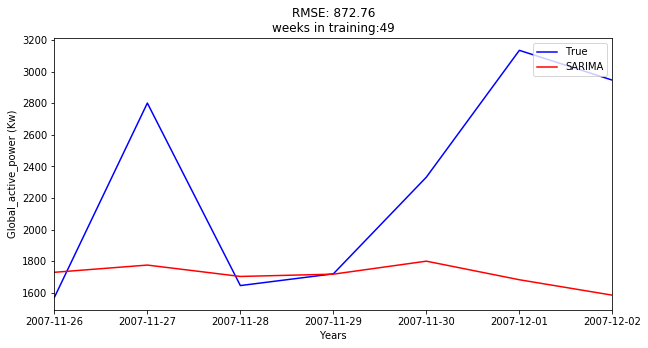

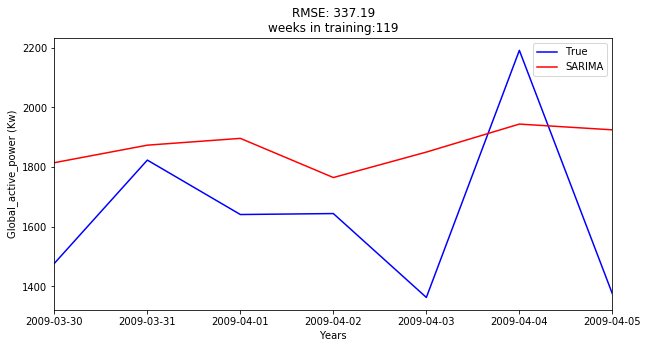

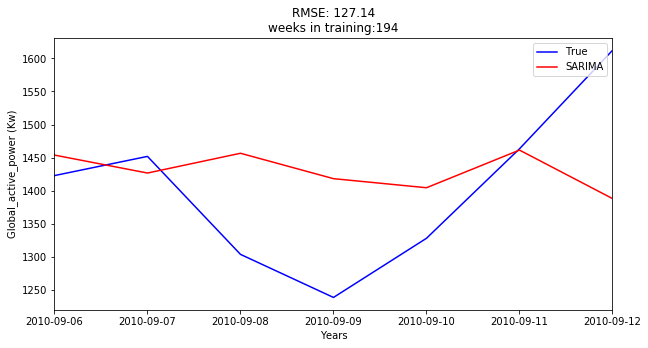

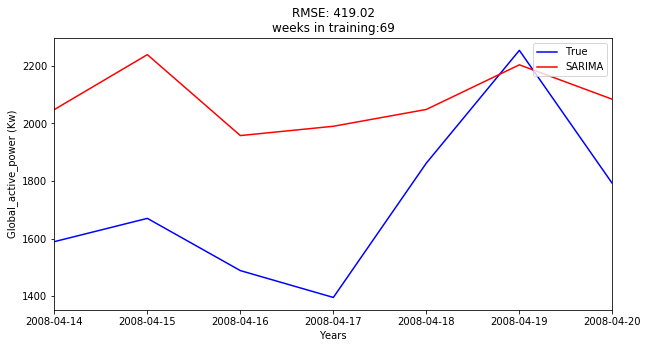

mean RMSE: 461.58


In [26]:
np.random.seed(0)
for i in np.random.randint(0, len(forecasted_values), 5):
    # Plot forecast results and display RMSE
    plt.figure(figsize=(10, 5))
    plt.plot(training_testing_folds[1][i], 'b', label='True')
    plt.plot(forecasted_values[i], 'r', alpha=1, label='SARIMA')

    plt.legend(loc='upper right')
    plt.title('RMSE: {}\nweeks in training:{}'.format(
        round(rmse_scores[i], 2),
        len(training_testing_folds[0][i])))
    plt.xlabel("Years")
    plt.ylabel("Global_active_power (Kw)")
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.show()
    
print('mean RMSE: %.2f' % np.mean(rmse_scores))

Looking at the plot above, we can see that SARIMA perfomed poorly on the testing set when the number of weeks in the training set is low, even if it follows the overall trend of the real data, with a mean **RMSE=461.58**. 

This poor performance may be partially explained by the fact that the **Global_active_power** feature depends on many other features that were neglected in the training of SARIMA. Therefore, the next model we are going to test is a Multivariate Linear Regression that takes into account all the other features on which the target variable may depend.

## II.2) Multivariate Linear Regression

### II.2.1) Preparing the dataset

In [27]:
# create a copy of the daily dataframe dedicated for the linear regression
lr_daily_df = daily_df.copy()

In [28]:
lr_daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0,14680.933594
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0,36946.667969
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0,19028.433594
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0,13131.900391
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0,20384.800781


### Adding lags of target variables to dataframe

In [29]:
# Adding the lag of the target variable from 2 steps back up

for i in range(1, 3):
    lr_daily_df["GAP_lag_{}".format(i)] = lr_daily_df['Global_active_power'].shift(i) # GAP is Global_active_power

# drop nan values after shifting
lr_daily_df = lr_daily_df.dropna()

In [30]:
lr_daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4,GAP_lag_1,GAP_lag_2
datetime,,,,,,,,,,
2006-12-18,2203.825928,161.792007,347373.6250,9247.200195,1063.0,2621.0,14018.0,19028.433594,3390.459961,1209.176025
2006-12-19,1666.193970,150.942001,348479.0000,7094.000000,839.0,7602.0,6197.0,13131.900391,2203.825928,3390.459961
2006-12-20,2225.748047,160.998001,348923.6250,9313.000000,0.0,2648.0,14063.0,20384.800781,1666.193970,2203.825928
2006-12-21,1716.624023,144.166000,346616.3125,7238.600098,1765.0,2623.0,10421.0,13801.400391,2225.748047,1666.193970
2006-12-22,2341.337891,186.906006,347305.7500,9897.000000,3151.0,350.0,11131.0,24390.300781,1716.624023,2225.748047


### Correlation between features

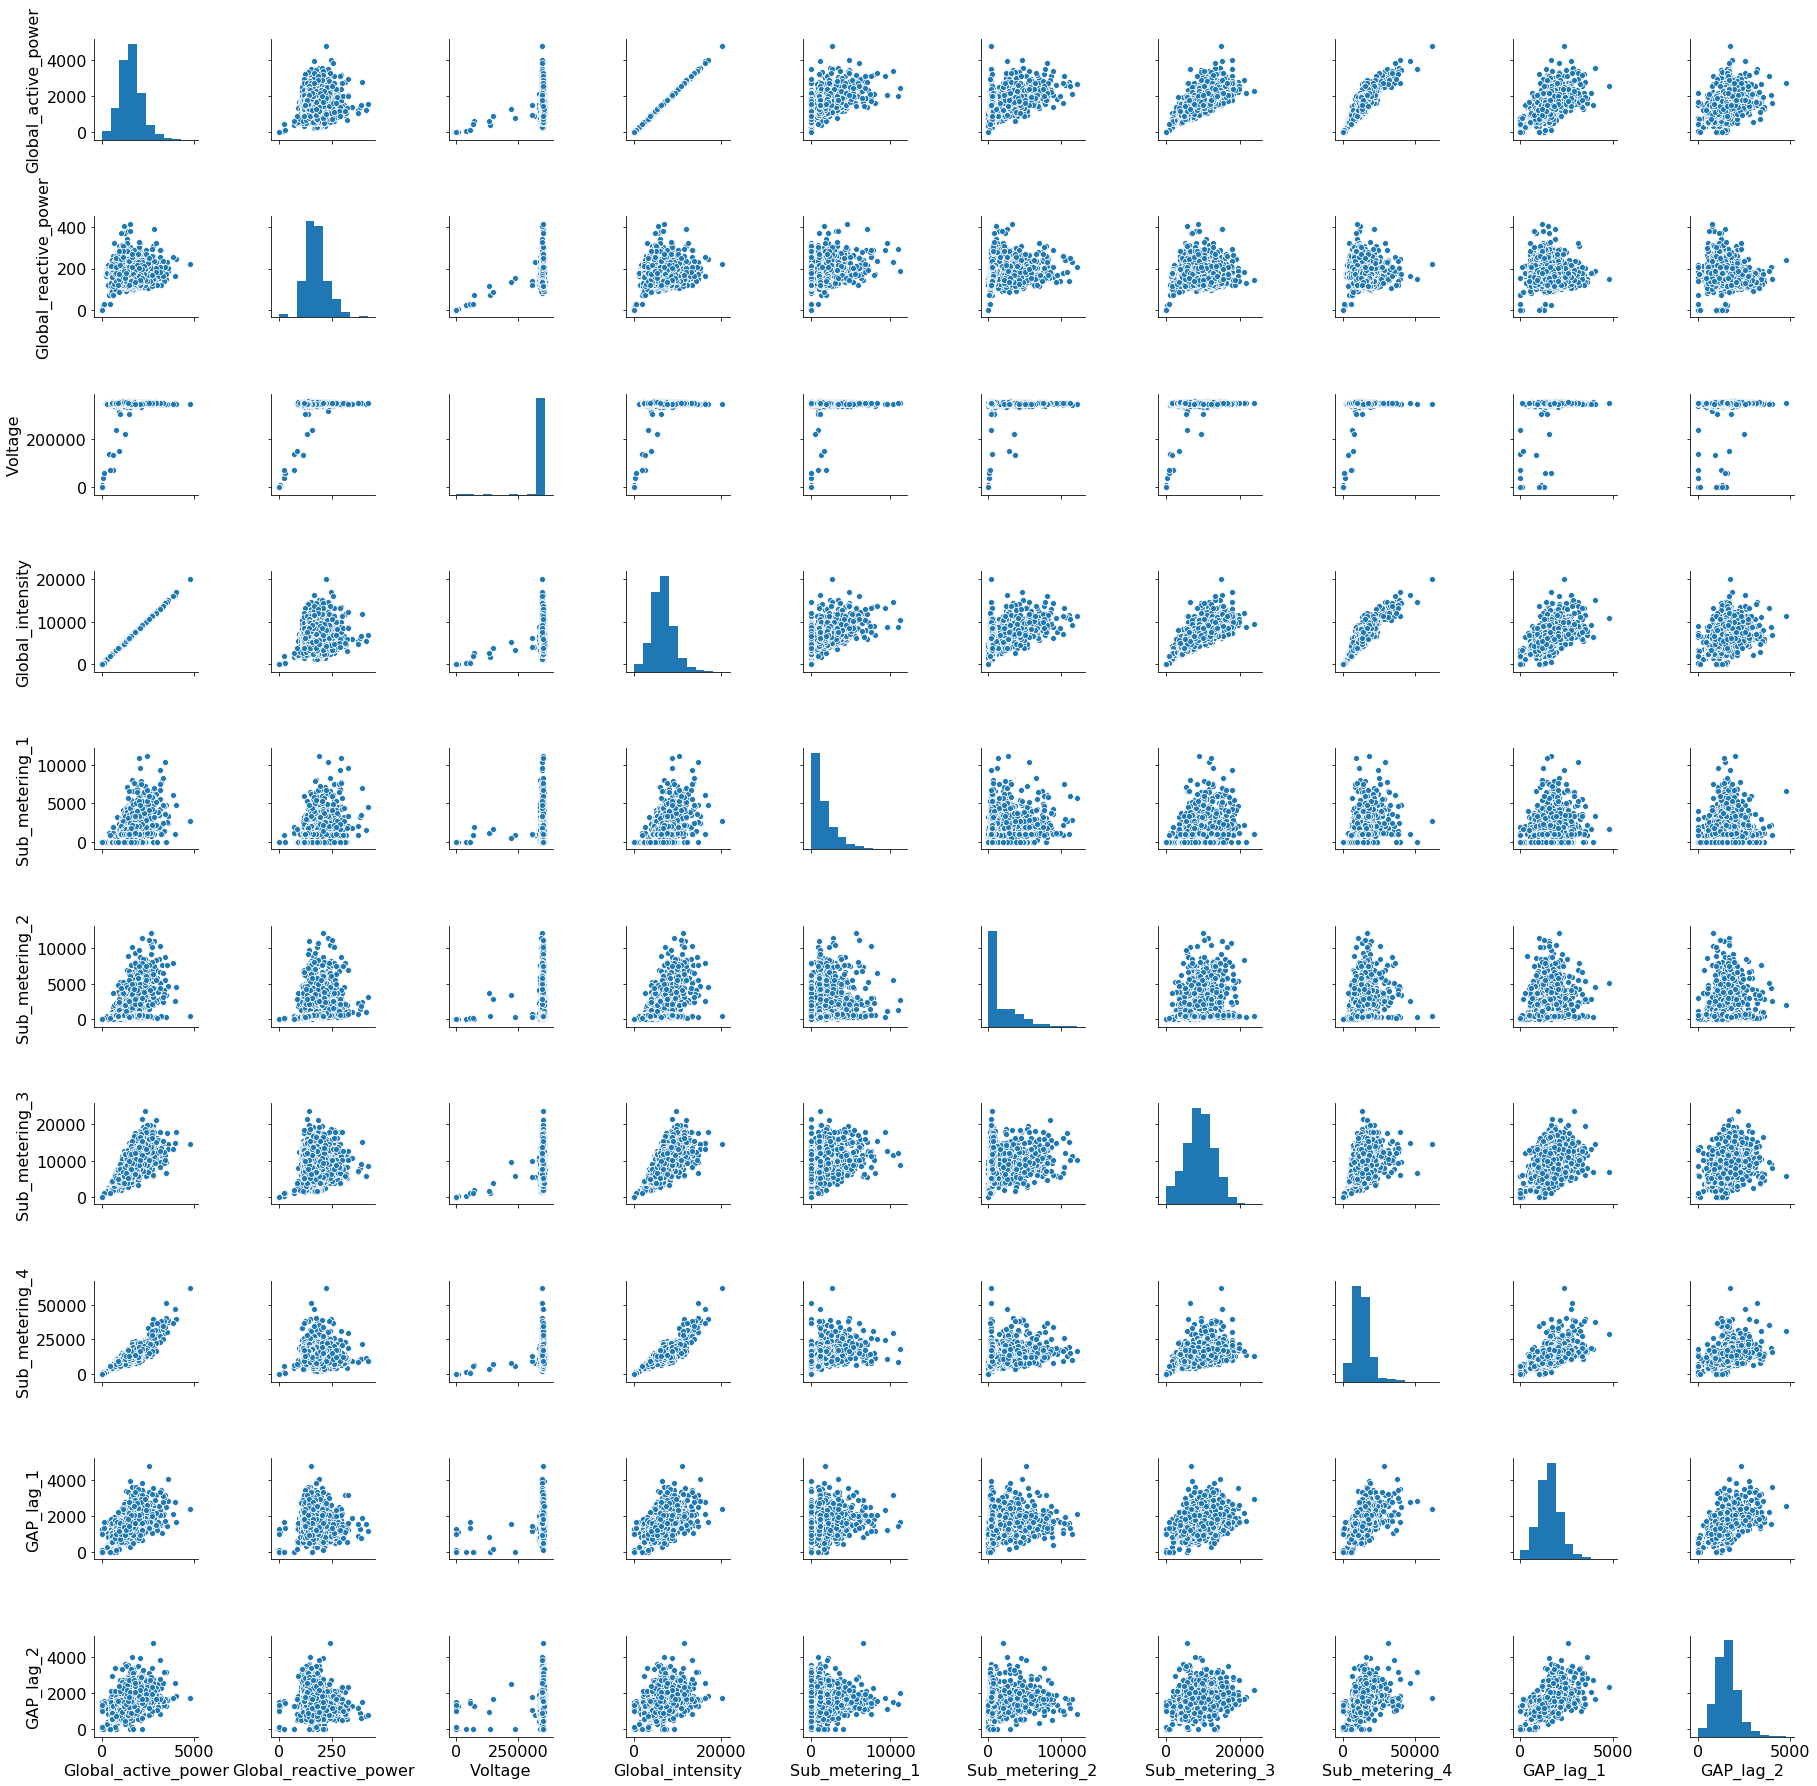

In [31]:
plt.rcParams['font.size'] = 16
sns.pairplot(lr_daily_df)
plt.show()

Some features seem to be highly correlated with each other, let's plot the correlation matrix to see this in more details.

In [32]:
plt.rcParams['figure.figsize'] = 15, 10
corr_matrix = lr_daily_df.corr()
corr_matrix.style.background_gradient(cmap="YlGnBu")

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4,GAP_lag_1,GAP_lag_2
Global_active_power,1,0.126237,0.273126,0.999219,0.550173,0.484417,0.751541,0.892925,0.620708,0.478751
Global_reactive_power,0.126237,1,0.342083,0.148047,0.330806,0.198571,0.120878,-0.0165842,-0.0861913,-0.217109
Voltage,0.273126,0.342083,1,0.277012,0.0911205,0.0792306,0.275529,0.233992,0.222093,0.143291
Global_intensity,0.999219,0.148047,0.277012,1,0.562095,0.493216,0.744104,0.890152,0.613979,0.468379
Sub_metering_1,0.550173,0.330806,0.0911205,0.562095,1,0.257324,0.321674,0.371667,0.238537,0.12015
Sub_metering_2,0.484417,0.198571,0.0792306,0.493216,0.257324,1,0.212174,0.269528,0.129723,0.0576039
Sub_metering_3,0.751541,0.120878,0.275529,0.744104,0.321674,0.212174,1,0.47974,0.457721,0.383683
Sub_metering_4,0.892925,-0.0165842,0.233992,0.890152,0.371667,0.269528,0.47974,1,0.643701,0.508443
GAP_lag_1,0.620708,-0.0861913,0.222093,0.613979,0.238537,0.129723,0.457721,0.643701,1,0.617575
GAP_lag_2,0.478751,-0.217109,0.143291,0.468379,0.12015,0.0576039,0.383683,0.508443,0.617575,1


As we can see, only the features **Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3, Sub_metering_4** and **GAP_lag_1** are highly correlated with the output variable **Global_active_power**. Hence we will drop all other features apart from these. 

However this is not the end of the process. One of the assumptions of linear regression is that the independent variables need to be uncorrelated with each other. If these variables are correlated with each other, then we need to keep only one of them and drop the rest. So let us check the correlation of the selected features with each other. This can be done by visually checking it from the above correlation matrix.

**Global_intensity** is highly correlated with **GAP_lag_1**, **Sub_metering_3** and **Sub_metering_4**. Hence we are going to keep only **Global_intensity** since its correlation with **Global_active_power** is higher.

### Selecting the most relevant features

In [33]:
df_before_split = lr_daily_df.drop([
    'Global_reactive_power', 'Voltage', 'GAP_lag_1', 'GAP_lag_2',
    'Sub_metering_3', 'Sub_metering_4'
], axis=1)

In [34]:
df_before_split.head()

,Global_active_power,Global_intensity,Sub_metering_1,Sub_metering_2
datetime,,,,
2006-12-18,2203.825928,9247.200195,1063.0,2621.0
2006-12-19,1666.193970,7094.000000,839.0,7602.0
2006-12-20,2225.748047,9313.000000,0.0,2648.0
2006-12-21,1716.624023,7238.600098,1765.0,2623.0
2006-12-22,2341.337891,9897.000000,3151.0,350.0


### Split data into training and testing sets

Same splitting methodology as SARIMA.

In [35]:
def split_df_to_weeks(df):
    '''
    function that takes as argument daily series and split it into weeks.
    '''
    folds = []

    for i in range(0, len(df), 7):
        folds.append(df[i:i + 7])

    return folds


def split_weekly_df_train_test(df):
    '''
    function that takes as argument daily series, split it into weeks
    and prepares the training/testing set using walk forward validation.
    '''
    folds = split_df_to_weeks(df)
    training = []
    testing = []

    for i in range(2, len(folds)):
        training.append(pd.concat(folds[:i]))
        testing.append(folds[i])

    return training, testing

In [36]:
training_testing_folds = split_weekly_df_train_test(df_before_split)

In [37]:
def fit_and_evaluate(training_testing_folds):
    '''
    plot: boolean to plot the results of the last train/test fold.
    '''
    # saving the training results
    fitted_model = []

    # saving the test results
    forecasted_values = []

    # performance array
    rmse_scores = []

    # create a regressor object
    regressor = LinearRegression()

    for training_fold, testing_fold in zip(training_testing_folds[0],
                                           training_testing_folds[1]):
        # extract training features and labels
        X_train = training_fold.drop('Global_active_power', axis=1)
        y_train = training_fold['Global_active_power']

        # extract test features and labels
        X_test = testing_fold.drop('Global_active_power', axis=1)
        y_test = testing_fold['Global_active_power']

        # fit the regressor with X and Y data
        regressor.fit(X_train, y_train)

        # predict
        y_pred = regressor.predict(X_test)
        
        # compute rmse and store it
        test_rmse = round(sqrt(mean_squared_error(y_test, y_pred)), 2)
        rmse_scores.append(test_rmse)
        
        # store predicted values
        forecasted_values.append(y_pred)

    return fitted_model, forecasted_values, rmse_scores

In [38]:
# fit the LR model
fitted_model, forecasted_values, rmse_scores = fit_and_evaluate(
    training_testing_folds)

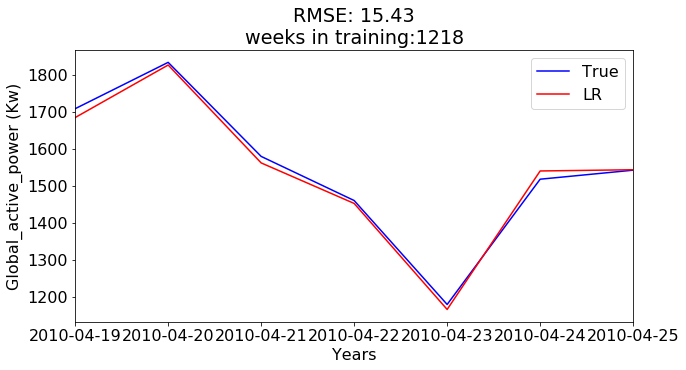

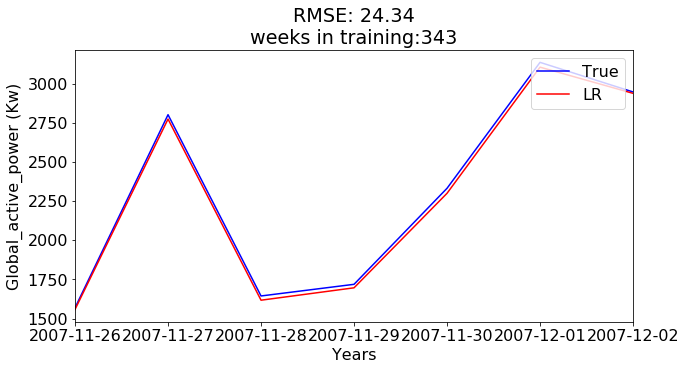

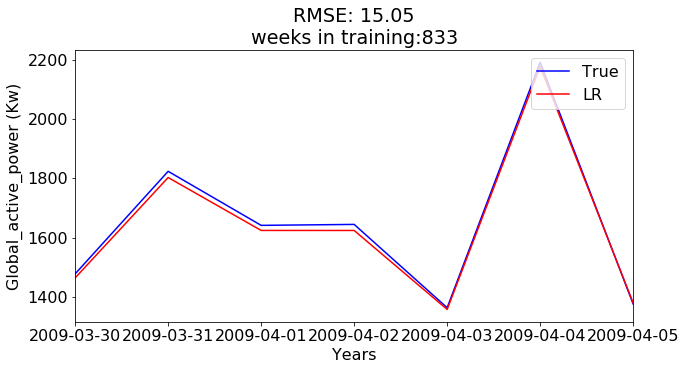

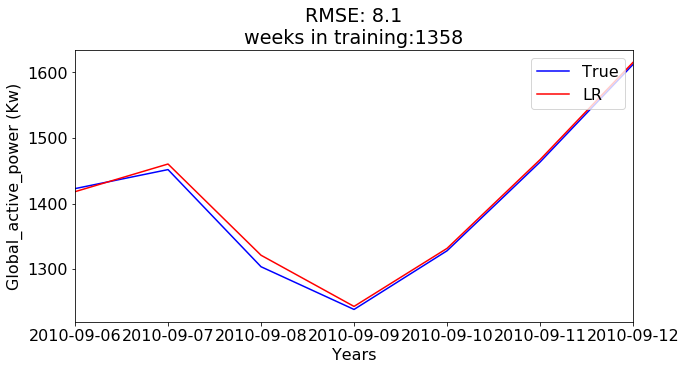

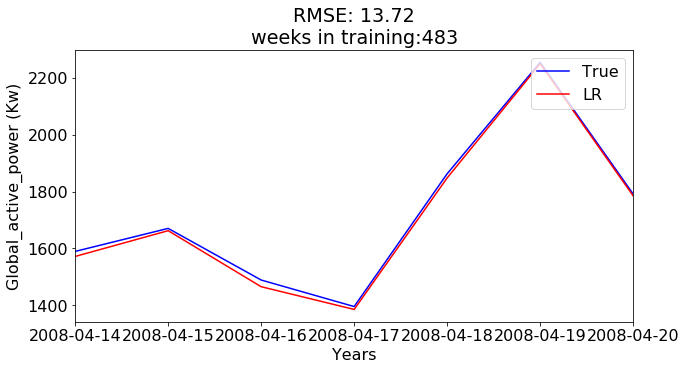

mean RMSE: 19.79


In [39]:
np.random.seed(0)
for i in np.random.randint(0, len(forecasted_values), 5):
    # Plot forecast results and display RMSE
    plt.figure(figsize=(10, 5))
    plt.plot(training_testing_folds[1][i]['Global_active_power'],
             'b',
             label='True')
    plt.plot(training_testing_folds[1][i].index,
             forecasted_values[i],
             'r',
             alpha=1,
             label='LR')

    plt.legend(loc='upper right')
    plt.title('RMSE: {}\nweeks in training:{}'.format(
        round(rmse_scores[i], 2), len(training_testing_folds[0][i])))
    plt.xlabel("Years")
    plt.ylabel("Global_active_power (Kw)")
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.show()

print('mean RMSE: %.2f' % np.mean(rmse_scores))

This model has performed better than SARIMA, with a mean **RMSE=19.79**, since other explanatory information has been included.

There are other things that can be done, such as adding more features regarding the time series (like the day of the week or if a day is a weekend or not), or maybe testing other models, such as decision trees, or random forests that may perform even better since they are a combination of weak learners.